In [1]:
library(ggplot2)
library(data.table)
theme_set(theme_bw())

Warning message:
“package ‘ggplot2’ was built under R version 4.2.3”
Warning message:
“package ‘data.table’ was built under R version 4.2.3”


In [2]:
tools = c('singlem', 'metaphlan', 'motus', 'kraken', 'sourmash', 'kaiju', 'map2b')
# Tools that do not have the correct taxonomy are tested only at the domain level. eg. Kaiju has NCBI taxonomy and MAP2B uses GTDB v202
correct_taxonomy_tools = c('singlem', 'metaphlan', 'motus', 'kraken', 'sourmash')

# debug
# tools = c('singlem','singlem2bp')
# correct_taxonomy_tools = tools

publication_names = data.table(
    tool = tools,
    publication_name = c('SingleM', 'MetaPhlAn', 'mOTUs', 'Kraken2', 'sourmash', 'Kaiju', 'MAP2B')#,'SingleM 2bp')
)
name_to_publication_name = function(names, correct_taxonomy_only=F){
    to_return = c()
    for (name in names){
        to_return = c(to_return, publication_names[tool==name]$publication_name)
    }
    if (correct_taxonomy_only){
        return(factor(to_return, levels=publication_names[tool %in% correct_taxonomy_tools]$publication_name))
    } else {
        return(factor(to_return, levels=publication_names$publication_name))
    }
}

In [3]:
setwd('~/m/msingle/mess/124_singlem-benchmarking/1_novel_strains/')
# base_dir = './'
base_dir = 'full_run7/checkout/1_novel_strains/' # Directory created when run in local scratch through queuing system

In [4]:
communities = gsub('^','marine',as.character(0:9))
# communities = gsub('^','marine',as.character(6)) # debug
communities

[1] "marine0" "marine1" "marine2" "marine3" "marine4" "marine5" "marine6"
 [8] "marine7" "marine8" "marine9"

In [5]:
d1 = data.table(expand.grid(tools, communities))
setnames(d1, c('tool', 'community'))
d1[1:3]

tool,community
<fct>,<fct>
singlem,marine0
metaphlan,marine0
motus,marine0


In [6]:
# output_singlem/opal/GCA_022615805.1_genomic.opal_report
readit = function(tool, community){
    to_read = paste(base_dir,'output_',tool,sep='','/opal/',community,'.opal_report')
    # print(to_read)
    return(fread(to_read))
}
d2 = d1[, readit(tool, community), by=list(tool,community)]
d2[1:3]

tool,community,tool,rank,metric,sample,value
<fct>,<fct>,<chr>,<chr>,<chr>,<chr>,<dbl>
singlem,marine0,Gold standard,kingdom,Bray-Curtis distance,SAMPLEID,0
singlem,marine0,Gold standard,phylum,Bray-Curtis distance,SAMPLEID,0
singlem,marine0,Gold standard,class,Bray-Curtis distance,SAMPLEID,0


In [7]:
dim(d2)

[1] 12720     7

In [8]:
setnames(d2, c('tool','community','blah','rank','metric','sample','value'))
d3 = d2[blah != 'Gold standard'][,.(tool, community, rank, metric, value)]
d3[1:3]
dim(d3)

tool,community,rank,metric,value
<fct>,<fct>,<chr>,<chr>,<dbl>
singlem,marine0,kingdom,Bray-Curtis distance,0.000753573
singlem,marine0,phylum,Bray-Curtis distance,0.018069324
singlem,marine0,class,Bray-Curtis distance,0.021082539


[1] 6350    5

In [9]:
bc = d3[metric=='Bray-Curtis distance']
dim(bc)
bc[1:10]

[1] 490   5

tool,community,rank,metric,value
<fct>,<fct>,<chr>,<chr>,<dbl>
singlem,marine0,kingdom,Bray-Curtis distance,0.000753573
singlem,marine0,phylum,Bray-Curtis distance,0.018069324
singlem,marine0,class,Bray-Curtis distance,0.021082539
singlem,marine0,order,Bray-Curtis distance,0.033167139
singlem,marine0,family,Bray-Curtis distance,0.037689163
singlem,marine0,genus,Bray-Curtis distance,0.050043568
singlem,marine0,species,Bray-Curtis distance,0.111626927
metaphlan,marine0,kingdom,Bray-Curtis distance,0.000000000
metaphlan,marine0,phylum,Bray-Curtis distance,0.117981329


In [10]:
orders = c('kingdom','phylum','class','order','family','genus','species')
bc[, rank := factor(rank, levels=orders)]
bc[1:3]

tool,community,rank,metric,value
<fct>,<fct>,<fct>,<chr>,<dbl>
singlem,marine0,kingdom,Bray-Curtis distance,0.000753573
singlem,marine0,phylum,Bray-Curtis distance,0.018069324
singlem,marine0,class,Bray-Curtis distance,0.021082539


In [11]:
average_bc = bc[tool %in% correct_taxonomy_tools][, mean(value), by=list(tool)][order(V1)]
average_bc

tool,V1
<fct>,<dbl>
singlem,0.05015916
metaphlan,0.14284309
kraken,0.16442284
sourmash,0.17457244
motus,0.18256788


In [12]:
bcc = bc[tool %in% correct_taxonomy_tools]
bcc[, tool2 := name_to_publication_name(tool, correct_taxonomy_only=T)]

Warning message:
“`qplot()` was deprecated in ggplot2 3.4.0.”
Warning message:
“The `size` argument of `element_rect()` is deprecated as of ggplot2 3.4.0.
ℹ Please use the `linewidth` argument instead.”


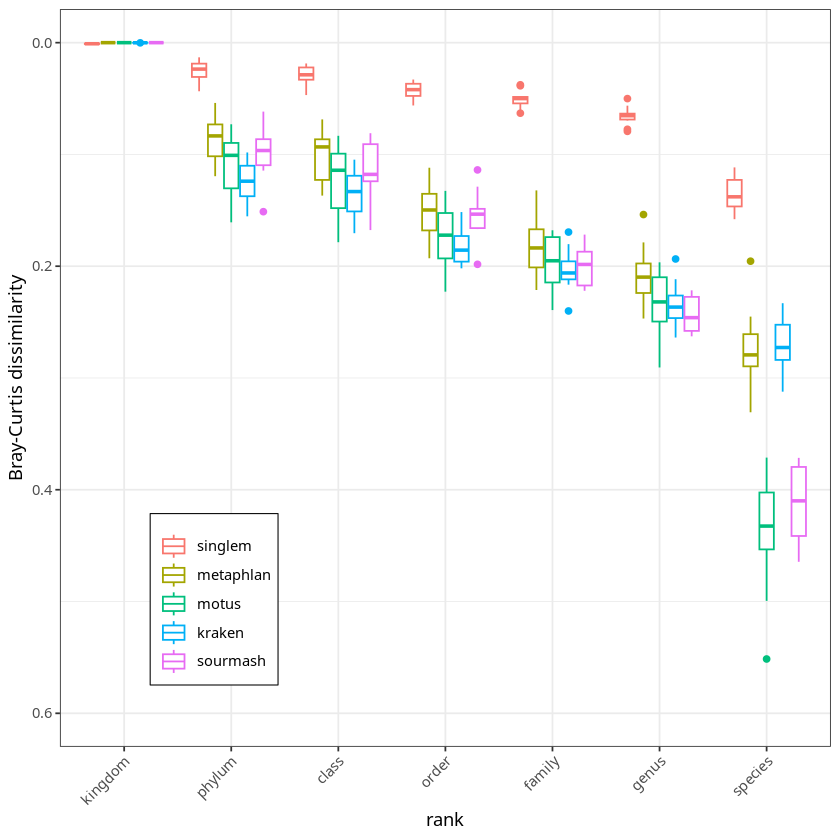

In [13]:

# Remove figure legend title, and put the legend in bottom left of plot, with a bounding box
qplot(data=bcc, rank, value, ylim=c(0.6,0), geom='boxplot', colour=tool, ylab='Bray-Curtis dissimilarity') + theme(axis.text.x = element_text(angle = 45, hjust = 1))+theme(legend.title=element_blank()) + theme(legend.position=c(0.2,0.2)) + theme(legend.background = element_rect(colour = "black", size = 0.3))

In [14]:
# How much better is singlem than the next best tool?
means = bcc[rank=='species', mean(value), by=tool][order(-V1)]
means
means[tool=='singlem', V1] - means[tool!='singlem', min(V1)]

tool,V1
<fct>,<dbl>
motus,0.4385136
sourmash,0.4121498
metaphlan,0.2723094
kraken,0.2721253
singlem,0.1358566


[1] -0.1362687

In [15]:
# write out bc
fwrite(bcc, 'bray-curtis.csv', sep='\t')

# Runtime comparison

In [16]:
# thread_numbers = as.character(c(1,8,32))
thread_numbers = as.character(c(1))

In [17]:
r1 = data.table(expand.grid(tools, thread_numbers, communities))
setnames(r1, c('tool', 'threads', 'community'))
r1 = r1[tool != 'coverm' | threads == '32']
r1[1:3]

tool,threads,community
<fct>,<fct>,<fct>
singlem,1,marine0
metaphlan,1,marine0
motus,1,marine0


In [18]:
r1[tool=='kracken', tool := 'kraken']
reed = function(tool,threads,community){
    # print(x)
    # f = paste(base_dir,'benchmarks/',x$tool,'/',x$community,'-',x$threads,'threads.benchmark',sep='')
    f = paste(base_dir,'benchmarks/',tool,'/',community,'-',threads,'threads.benchmark',sep='')
    # print(f)
    return(fread(f))
}
r2 = r1[, reed(tool,threads,community), by=list(tool,threads,community)]
getwd()
r2[1:3]

[1] "/mnt/hpccs01/work/microbiome/msingle/mess/124_singlem-benchmarking/1_novel_strains"

tool,threads,community,s,h:m:s,max_rss,max_vms,max_uss,max_pss,io_in,io_out,mean_load,cpu_time
<fct>,<fct>,<fct>,<dbl>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
singlem,1,marine0,5732.322,1:35:32,2112.85,4842.11,2094.95,2096.73,37.55,1530.55,84.49,350.30
metaphlan,1,marine0,29674.625,8:14:34,17540.51,18959.26,17499.11,17514.46,6608.77,9705.36,106.13,74.37
motus,1,marine0,30977.597,8:36:17,10906.66,11918.58,10891.75,10894.42,30.42,4.30,101.52,450.61


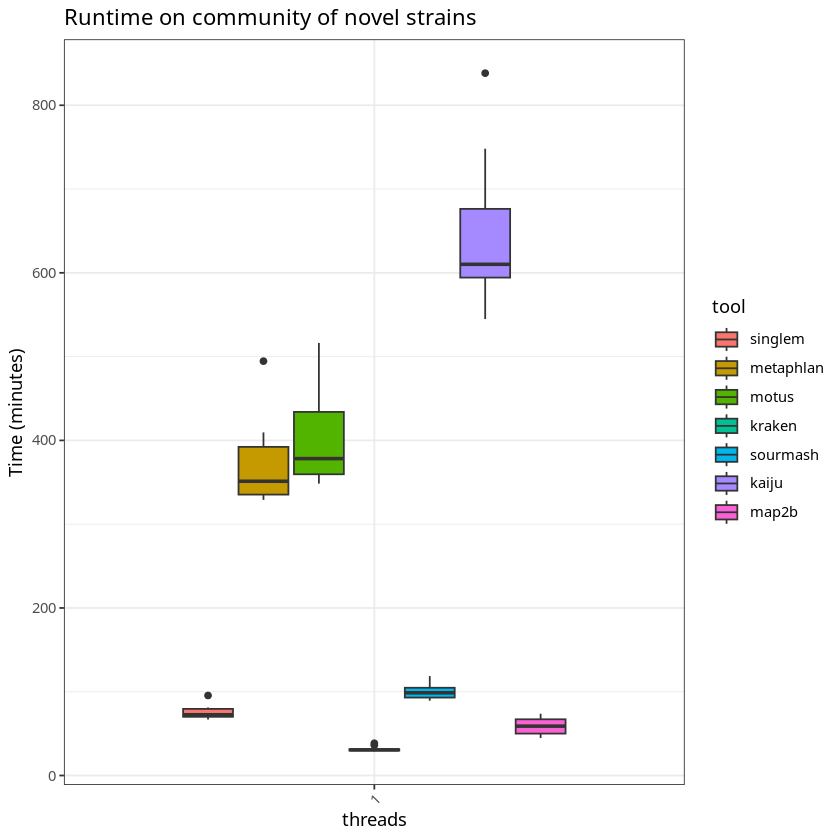

In [19]:
qplot(data=r2, threads, s/60, geom='boxplot', fill=tool, ylab='Time (minutes)', main='Runtime on community of novel strains') + theme(axis.text.x = element_text(angle = 45, hjust = 1))

`geom_line()`: Each group consists of only one observation.
ℹ Do you need to adjust the group aesthetic?


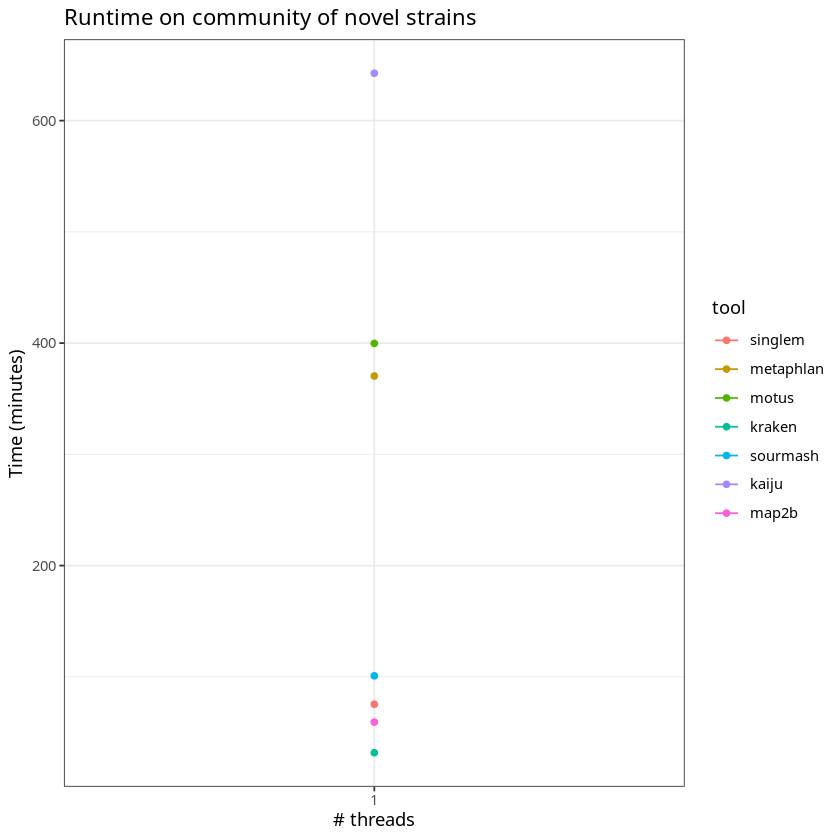

In [20]:
r3 = r2[, .(mean_s = mean(s)), by=list(tool,threads)]
# r3
qplot(data=r3, as.numeric(threads), mean_s/60, geom='point', ylab='Time (minutes)', xlab='# threads', main='Runtime on community of novel strains', colour=tool)+geom_line()+scale_x_continuous(breaks=c(1,2,3), labels=c(1,8,32))

`geom_line()`: Each group consists of only one observation.
ℹ Do you need to adjust the group aesthetic?


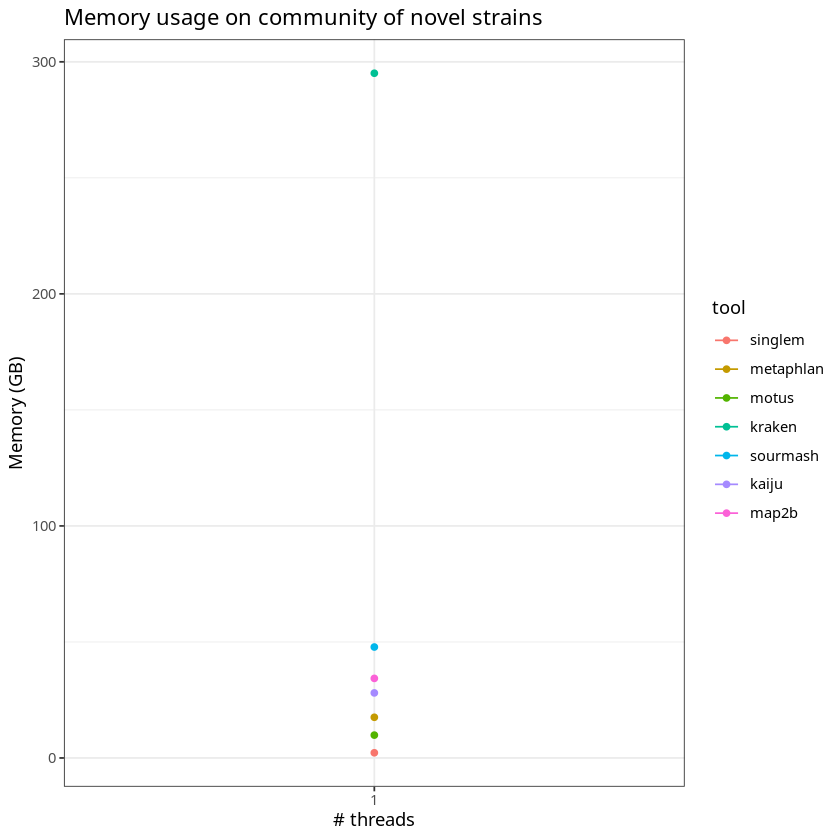

In [21]:
# RAM
r4 = r2[, .(mean_mem = mean(max_rss)), by=list(tool,threads)]
qplot(data=r4, as.numeric(threads), mean_mem/1000, geom='point', ylab='Memory (GB)', xlab='# threads', main='Memory usage on community of novel strains', colour=tool)+geom_line()+scale_x_continuous(breaks=c(1,2,3), labels=c(1,8,32))

In [22]:
r4

tool,threads,mean_mem
<fct>,<fct>,<dbl>
singlem,1,2246.569
metaphlan,1,17538.760
motus,1,9854.325
kraken,1,295077.007
sourmash,1,47819.432
kaiju,1,28042.873
map2b,1,34299.571


In [23]:
## Commented out because it takes a while to run

# Reads per minute
# read_counts = data.table(community=communities)
# read_counts2 = read_counts[, fread(cmd=paste('zcat local_reads/',community,'.1.fq.gz | wc -l',sep='')), by=community]
# read_counts2

# rcm = merge(r2[threads==1], read_counts2, by='community')
# rcm[, rpm := (V1/4)/s*60 *2] # times 2 because we only have half the reads in count
# rcm[1:3]

In [24]:
# Write rc3
fwrite(r2, 'runtime.csv', sep='\t')

# Full set of stats of each method

In [25]:
s1 = dcast(d3, tool+rank~metric, value.var='value', fun.aggregate=mean)

s1 = s1[tool %in% correct_taxonomy_tools]
s1[, tool2 := name_to_publication_name(tool, correct_taxonomy_only=T)]
s1[, tool := tool2]
s1[, tool2 := NULL]

# dcast(d3[metric %in% non_ranked_metrics], tool~metric, value.var='value', fun.aggregate=mean)

s1[, rank := factor(rank, levels=orders)]
s1 = s1[order(rank, tool)]
s1[1:3]
fwrite(s1, 'opal_summary.csv', sep='\t')

tool,rank,Bray-Curtis distance,Completeness,F1 score,False negatives,False positives,Jaccard index,L1 norm error,Purity,Shannon diversity,Shannon equitability,Sum of abundances,Taxon counts,True positives,Unweighted UniFrac (CAMI),Unweighted UniFrac error,Weighted UniFrac (CAMI),Weighted UniFrac error
<fct>,<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
SingleM,kingdom,0.001005178,1,0.6666667,0,1,0.5,0.002010356,0.5,NaN,NaN,NaN,NaN,1,NaN,NaN,NaN,NaN
MetaPhlAn,kingdom,0.000000000,1,1.0000000,0,0,1.0,0.000000000,1.0,NaN,NaN,NaN,NaN,1,NaN,NaN,NaN,NaN
mOTUs,kingdom,0.000000000,1,1.0000000,0,0,1.0,0.000000000,1.0,NaN,NaN,NaN,NaN,1,NaN,NaN,NaN,NaN


# Relationship between relative abundance and accuracy

In [26]:
base = base_dir #'/mnt/hpccs01/work/microbiome/msingle/mess/124_singlem-benchmarking/1_novel_strains/full_run1/checkout/1_novel_strains/'
# base = './'

truth_profiles = data.table(community=communities)
truth_profiles2 = truth_profiles[, fread(paste(base,'/truths/',community,'.condensed',sep='')), by=community]
truth_profiles2[, sample := NULL]
setnames(truth_profiles2, 'coverage', 'true_coverage')

tool_profiles = data.table(expand.grid(tools, communities))
setnames(tool_profiles, c('tool','community'))
tool_profiles2 = tool_profiles[, fread(paste(base,'/output_',tool,'/',tool,'/',community,'.profile',sep='')), by=list(tool,community)]
tool_profiles2[, sample := NULL]
setnames(tool_profiles2, 'coverage', 'tool_coverage')
tool_profiles2[, taxonomy := gsub('Root;','',gsub('; ',';',taxonomy))]

# Kraken has filled profiles, so remove all except species annotations
tool_profiles3 = rbind(
    tool_profiles2[tool != 'kraken'],
    tool_profiles2[tool == 'kraken' & taxonomy %like% 's__']
)
tool_profiles3[tool=='kraken'][1:5]
# cartesian product so the all = T works for each tool
community_tool = data.table(expand.grid(tools, communities))
setnames(community_tool, c('tool','community'))
truth_profiles3 = merge(truth_profiles2, community_tool, all=T, allow.cartesian=T)
# truth_profiles3

m = merge(truth_profiles3, tool_profiles3, by=c('taxonomy','community','tool'), all=T)

m[is.na(tool_coverage), tool_coverage := 0]
m[is.na(true_coverage), true_coverage := 0]

tool,community,tool_coverage,taxonomy
<fct>,<fct>,<dbl>,<chr>
kraken,marine0,0.03469,d__Bacteria;p__Proteobacteria;c__Gammaproteobacteria;o__Enterobacterales;f__Enterobacteriaceae;g__Pantoea;s__Pantoea stewartii
kraken,marine0,0.00035,d__Bacteria;p__Proteobacteria;c__Gammaproteobacteria;o__Enterobacterales;f__Enterobacteriaceae;g__Pantoea;s__Pantoea ananatis
kraken,marine0,0.00027,d__Bacteria;p__Proteobacteria;c__Gammaproteobacteria;o__Enterobacterales;f__Enterobacteriaceae;g__Pantoea;s__Pantoea allii
kraken,marine0,0.00009,d__Bacteria;p__Proteobacteria;c__Gammaproteobacteria;o__Enterobacterales;f__Enterobacteriaceae;g__Pantoea;s__Pantoea deleyi
kraken,marine0,0.00003,d__Bacteria;p__Proteobacteria;c__Gammaproteobacteria;o__Enterobacterales;f__Enterobacteriaceae;g__Pantoea;s__Pantoea dispersa


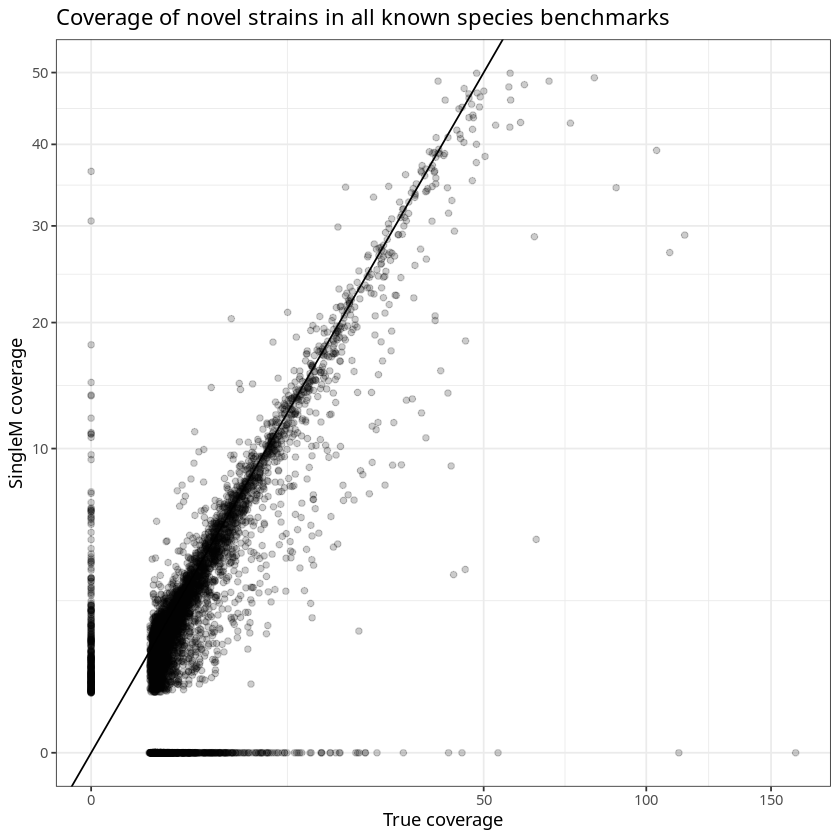

In [27]:
# Just for SingleM
qplot(data=m[tool=='singlem' & tool_coverage < 50][grep('s__',taxonomy)], true_coverage, tool_coverage, geom='point', xlab='True coverage', ylab='SingleM coverage', main='Coverage of novel strains in all known species benchmarks', alpha=I(1/5)) + geom_abline(intercept=0, slope=1)+scale_x_sqrt()+scale_y_sqrt()

In [28]:
m[tool=='kraken'][grep('s__',taxonomy)][community=='marine6'][order(-tool_coverage)][1:3]

taxonomy,community,tool,true_coverage,tool_coverage
<chr>,<fct>,<fct>,<dbl>,<dbl>
d__Bacteria;p__Bacteroidota;c__Bacteroidia;o__Cytophagales;f__Hymenobacteraceae;g__Hymenobacter;s__Hymenobacter sp004684095,marine6,kraken,251.1870,0.12274
d__Bacteria;p__Bacteroidota;c__Bacteroidia;o__Bacteroidales;f__Bacteroidaceae;g__Bacteroides;s__Bacteroides sp902362375,marine6,kraken,73.2114,0.02717
d__Bacteria;p__Myxococcota_A;c__UBA796;o__UBA796;f__SXON01;g__SXON01;s__SXON01 sp903885375,marine6,kraken,56.9791,0.02695


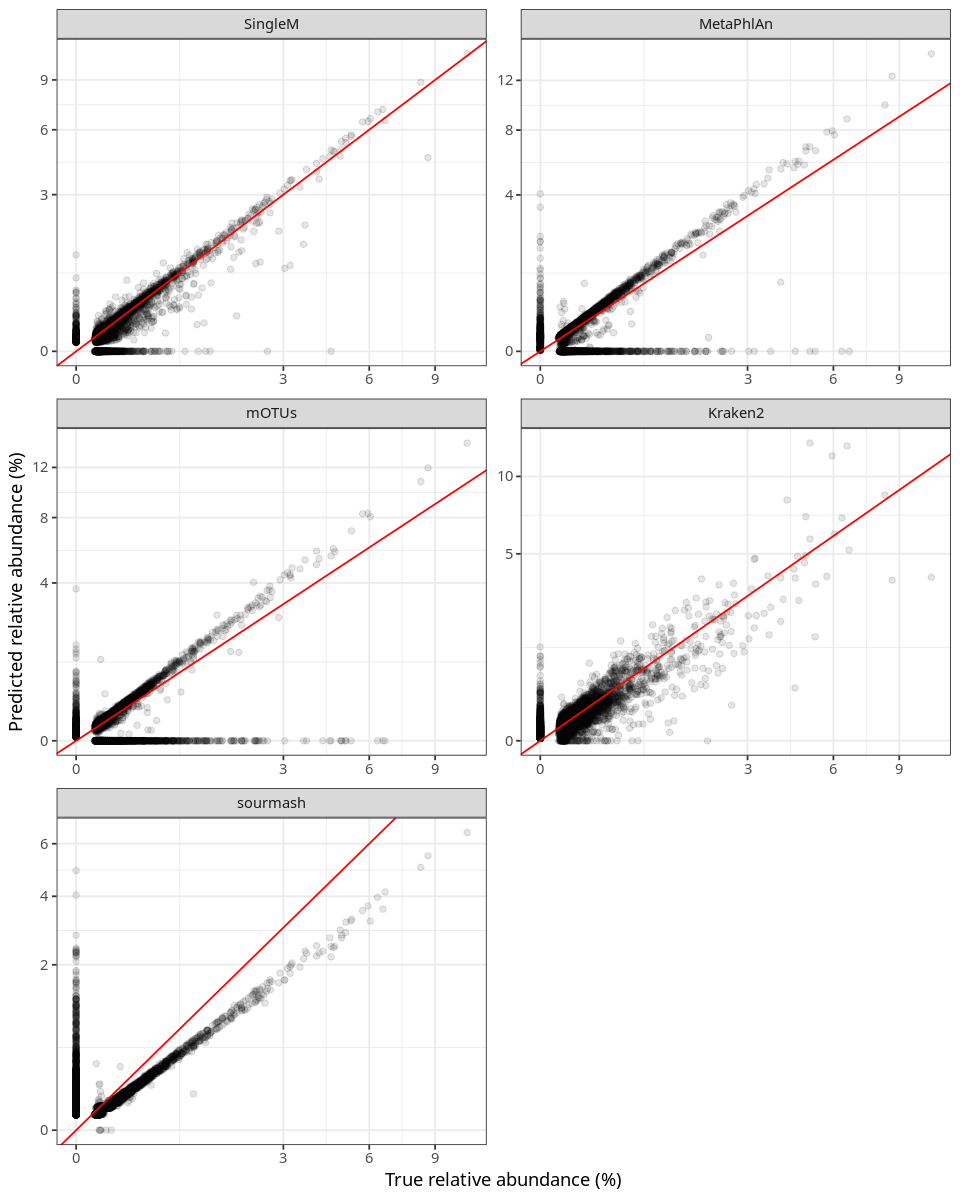

In [29]:
# All tools
# First convert to relabund
m[, tool_coverage_relabund := tool_coverage/sum(tool_coverage)*100, by=list(tool, community)]
m[, true_coverage_relabund := true_coverage/sum(true_coverage)*100, by=list(tool, community)]

m = m[tool %in% correct_taxonomy_tools]
m[, tool2 := name_to_publication_name(tool, correct_taxonomy_only=T)]

original_width_height = c(getOption('repr.plot.width'), getOption('repr.plot.height'))
options(repr.plot.width=8, repr.plot.height=10)
qplot(data=m[grep('s__',taxonomy)], true_coverage_relabund, tool_coverage_relabund, geom='point', xlab='True relative abundance (%)', ylab='Predicted relative abundance (%)', alpha=I(1/10)) + geom_abline(intercept=0, slope=1, colour='red')+scale_x_sqrt()+scale_y_sqrt()+facet_wrap(~tool2, ncol=2, scales='free')
options(repr.plot.width=original_width_height[1], repr.plot.height=original_width_height[2])

In [30]:
# What's with the 20+ coverage genome?

# marine0 = fread(paste(base,'truths/marine0.condensed',sep=''))
# marine0[, sample := 'marine0']
# setnames(marine0, 'coverage', 'true_coverage')
# singlem_marine0 = fread(paste(base,'output_singlem/singlem/marine0.profile',sep=''))
# setnames(singlem_marine0, 'coverage', 'singlem_coverage')
# singlem_marine0[, taxonomy := gsub('Root;','',gsub('; ',';',taxonomy))]
# # singlem_marine0[grep('s__',taxonomy)][1:3]

# m[true_coverage > 20 & singlem_coverage ==0]
# singlem_marine0[grep('g__Pseudomonas_E',taxonomy)]
# # => So it backed off to species level for some reason. Unsure why.

In [31]:
# Fraction of genomes which were missed at each binned coverage levels
# m[, .(missed = sum(singlem_coverage==0)/.N*100, .N), by=.(cut(true_coverage, breaks=c(0,2,4,6,8,10,20,40,1000)))][order(cut)]

In [32]:
# How well does genus level rescue some of the missing genomes? First need to remake the table with genus level, annoying since kraken profiles are filled, when the rest aren't.

# Kraken has filled profiles, so remove all except species annotations
tool_profiles3_genus = rbind(
    tool_profiles2[tool != 'kraken'],
    tool_profiles2[tool == 'kraken' & taxonomy %like% 'g__']
)
tool_profiles3_genus[tool=='kraken'][1:5]

m_genus = merge(truth_profiles3, tool_profiles3_genus, by=c('taxonomy','community','tool'), all=T)

m_genus[is.na(tool_coverage), tool_coverage := 0]
m_genus[is.na(true_coverage), true_coverage := 0]

m_genus[1:3]

m_genus[, genus_and_up := gsub(';s__.*','',taxonomy)]

# m[grep('g__',taxonomy)][1:10]
m2_genus = m_genus[, .(tool_coverage=sum(tool_coverage), true_coverage=sum(true_coverage)), by=.(community, genus_and_up, tool)]

m2_genus[grep('g__',genus_and_up)][tool=='kraken' & true_coverage > 0][1:3]

tool,community,tool_coverage,taxonomy
<fct>,<fct>,<dbl>,<chr>
kraken,marine0,0.03577,d__Bacteria;p__Proteobacteria;c__Gammaproteobacteria;o__Enterobacterales;f__Enterobacteriaceae;g__Pantoea
kraken,marine0,0.03011,d__Bacteria;p__Proteobacteria;c__Gammaproteobacteria;o__Enterobacterales;f__Enterobacteriaceae;g__Serratia_A
kraken,marine0,0.00921,d__Bacteria;p__Proteobacteria;c__Gammaproteobacteria;o__Enterobacterales;f__Enterobacteriaceae;g__Enterobacter
kraken,marine0,0.00476,d__Bacteria;p__Proteobacteria;c__Gammaproteobacteria;o__Enterobacterales;f__Enterobacteriaceae;g__Yersinia
kraken,marine0,0.00376,d__Bacteria;p__Proteobacteria;c__Gammaproteobacteria;o__Enterobacterales;f__Enterobacteriaceae;g__Providencia


taxonomy,community,tool,true_coverage,tool_coverage
<chr>,<fct>,<fct>,<dbl>,<dbl>
d__Archaea,marine0,singlem,0,2.95
d__Archaea,marine1,singlem,0,2.75
d__Archaea,marine2,singlem,0,3.89


community,genus_and_up,tool,tool_coverage,true_coverage
<fct>,<chr>,<fct>,<dbl>,<dbl>
marine0,d__Bacteria;p__Acidobacteriota;c__Acidobacteriae;o__Acidobacteriales;f__SbA1;g__Gp1-AA124,kraken,0,1.83878
marine1,d__Bacteria;p__Acidobacteriota;c__Acidobacteriae;o__Acidobacteriales;f__SbA1;g__Gp1-AA124,kraken,0,1.67182
marine2,d__Bacteria;p__Acidobacteriota;c__Acidobacteriae;o__Acidobacteriales;f__SbA1;g__Gp1-AA124,kraken,0,1.81169


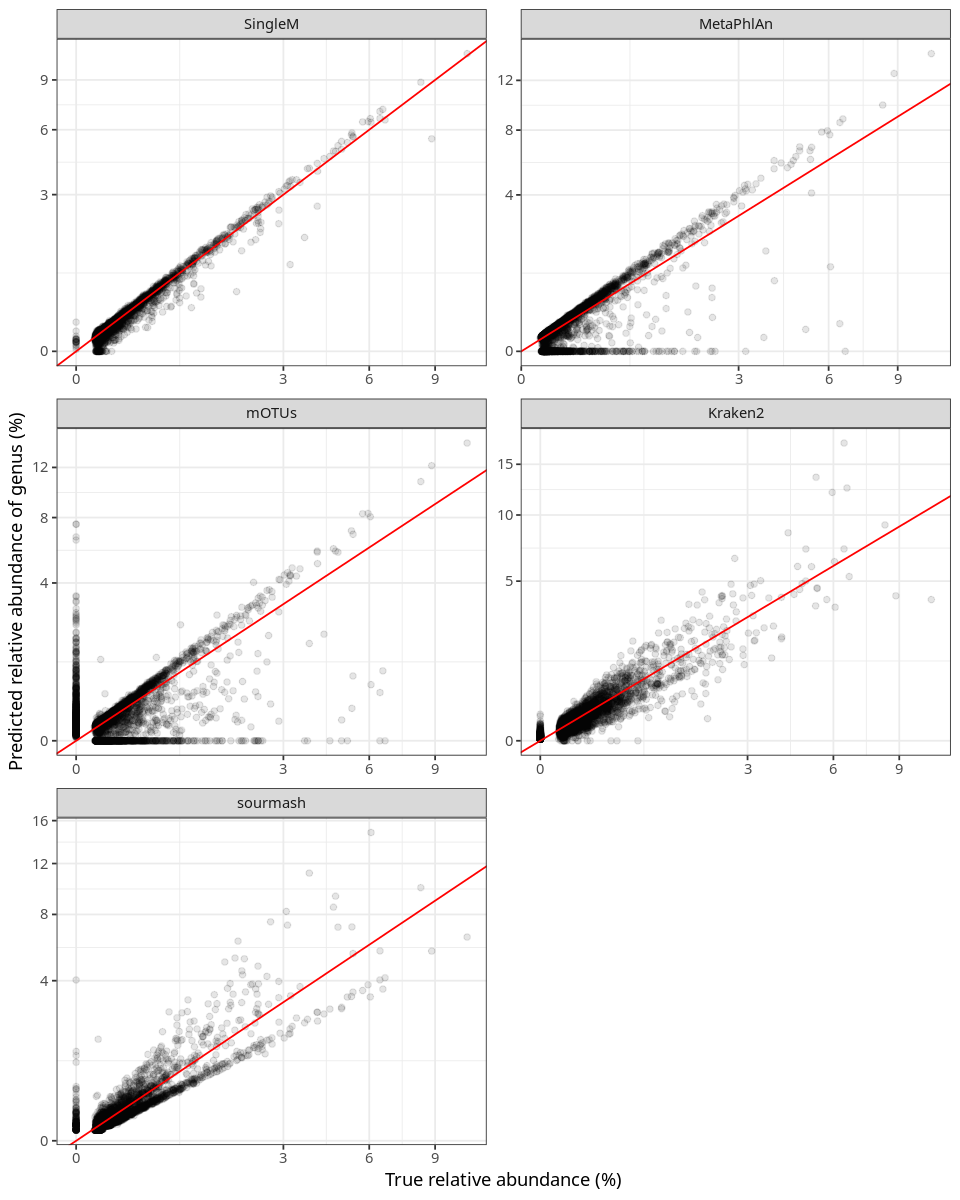

In [33]:
m2_genus[, tool_coverage_relabund := tool_coverage/sum(tool_coverage)*100, by=list(tool, community)]
m2_genus[, true_coverage_relabund := true_coverage/sum(true_coverage)*100, by=list(tool, community)]

m2_genus = m2_genus[tool %in% correct_taxonomy_tools]
m2_genus[, tool2 := name_to_publication_name(tool, correct_taxonomy_only=T)]

original_width_height = c(getOption('repr.plot.width'), getOption('repr.plot.height'))
options(repr.plot.width=8, repr.plot.height=10)
qplot(data=m2_genus[grep('g__',genus_and_up)], true_coverage_relabund, tool_coverage_relabund, geom='point', xlab='True relative abundance (%)', ylab='Predicted relative abundance of genus (%)', alpha=I(1/10)) + geom_abline(intercept=0, slope=1, colour='red')+scale_x_sqrt()+scale_y_sqrt()+facet_wrap(~tool2, ncol=2, scales='free')
options(repr.plot.width=original_width_height[1], repr.plot.height=original_width_height[2])

`geom_smooth()` using method = 'gam' and formula = 'y ~ s(x, bs = "cs")'


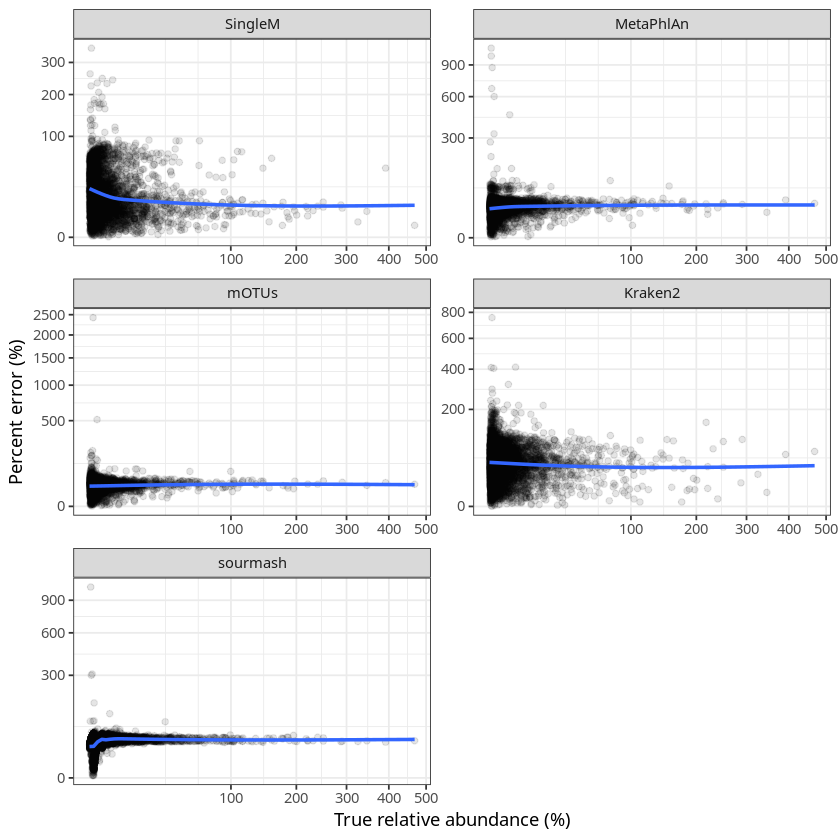

In [34]:
# Percent error at the species level for each tool
m_error = m[true_coverage>0 & tool_coverage>0]
m_error[, error := abs(true_coverage_relabund - tool_coverage_relabund)/true_coverage_relabund*100]

qplot(data=m_error, true_coverage, error, geom='point', xlab='True relative abundance (%)', ylab='Percent error (%)', alpha=I(1/10))+scale_x_sqrt()+scale_y_sqrt()+facet_wrap(~tool2, ncol=2, scales='free')+geom_smooth(se=F)

# What fraction of singlem profiles are assigned to the species level?

In [36]:
# m
assigned = m[tool2=='SingleM'][,sum(.SD[grep('s__',taxonomy)]$tool_coverage_relabund),by=community]
assigned
mean(assigned$V1)

community,V1
<fct>,<dbl>
marine0,91.36661
marine1,88.02995
marine2,89.98332
marine3,87.80878
marine4,91.93918
marine5,84.65157
marine6,88.91735
marine7,90.76807
marine8,86.72296


[1] 88.86118